#1. Importing Libraries & Data Exploration

In [ ]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from datetime import datetime
from pyspark.sql.functions import year
from pyspark.sql.functions import to_date
from pyspark.sql.functions import to_timestamp,date_format
from pyspark.sql.functions import col

In [ ]:
spark = SparkSession.builder.appName("CrimeAnalysis").getOrCreate()

In [ ]:
#Import and read the data
data = pd.read_csv("/content/drive/MyDrive/Crime_Data_from_2020_to_Present.csv")
df = spark.read.csv("/content/drive/MyDrive/Crime_Data_from_2020_to_Present.csv", header=True, inferSchema=True)

#2. Data Pre-processing

In [ ]:
df.show(10)

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+-------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+--------+--------+--------------------+------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|            Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+-------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+--------+

In [ ]:
#Remove whitespace in column names
new_cols = list(map(lambda item : item.replace(" ","_").upper(),df.columns))
df = df.toDF(*new_cols)
df.printSchema()

root
 |-- DR_NO: integer (nullable = true)
 |-- DATE_RPTD: string (nullable = true)
 |-- DATE_OCC: string (nullable = true)
 |-- TIME_OCC: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA_NAME: string (nullable = true)
 |-- RPT_DIST_NO: integer (nullable = true)
 |-- PART_1-2: integer (nullable = true)
 |-- CRM_CD: integer (nullable = true)
 |-- CRM_CD_DESC: string (nullable = true)
 |-- MOCODES: string (nullable = true)
 |-- VICT_AGE: integer (nullable = true)
 |-- VICT_SEX: string (nullable = true)
 |-- VICT_DESCENT: string (nullable = true)
 |-- PREMIS_CD: integer (nullable = true)
 |-- PREMIS_DESC: string (nullable = true)
 |-- WEAPON_USED_CD: integer (nullable = true)
 |-- WEAPON_DESC: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- STATUS_DESC: string (nullable = true)
 |-- CRM_CD_1: integer (nullable = true)
 |-- CRM_CD_2: integer (nullable = true)
 |-- CRM_CD_3: integer (nullable = true)
 |-- CRM_CD_4: integer (nullable = true)
 |-- L

In [ ]:
#Count duplicate row
df.groupBy(df.columns).count().where(F.col('count') > 1).select(F.sum('count')).show()

+----------+
|sum(count)|
+----------+
|      null|
+----------+



In [ ]:
#Select columns to be used
df1 = df.select(['Vict_Age','Vict_Sex','AREA_NAME','Crm_Cd','Crm_Cd_Desc','Weapon_Used_Cd','Weapon_Desc','Premis_Cd','Premis_Desc','DATE_OCC','AREA','Premis_Cd','TIME_OCC'])

In [ ]:
#Check if is there any missing value present in the dataframe
print(df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show())

+--------+--------+---------+------+-----------+--------------+-----------+---------+-----------+--------+----+---------+--------+
|Vict_Age|Vict_Sex|AREA_NAME|Crm_Cd|Crm_Cd_Desc|Weapon_Used_Cd|Weapon_Desc|Premis_Cd|Premis_Desc|DATE_OCC|AREA|Premis_Cd|TIME_OCC|
+--------+--------+---------+------+-----------+--------------+-----------+---------+-----------+--------+----+---------+--------+
|       0|   65558|        0|     0|          0|        315914|     315914|        5|        211|       0|   0|        5|       0|
+--------+--------+---------+------+-----------+--------------+-----------+---------+-----------+--------+----+---------+--------+

None


In [ ]:
#replace null values in vict_sex, weapon_used_cd, and weapon_desc
df1 = df1.fillna({'VICT_SEX': 'X',
                'WEAPON_USED_CD': 0,
                'WEAPON_DESC': 'None'})
print(df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show())

+--------+--------+---------+------+-----------+--------------+-----------+---------+-----------+--------+----+---------+--------+
|Vict_Age|Vict_Sex|AREA_NAME|Crm_Cd|Crm_Cd_Desc|Weapon_Used_Cd|Weapon_Desc|Premis_Cd|Premis_Desc|DATE_OCC|AREA|Premis_Cd|TIME_OCC|
+--------+--------+---------+------+-----------+--------------+-----------+---------+-----------+--------+----+---------+--------+
|       0|       0|        0|     0|          0|             0|          0|        5|        211|       0|   0|        5|       0|
+--------+--------+---------+------+-----------+--------------+-----------+---------+-----------+--------+----+---------+--------+

None


In [ ]:
df1 = df1.dropna(how='any', subset = ['Vict_Age','Vict_Sex','Crm_Cd','Crm_Cd_Desc','Weapon_Used_Cd','Weapon_Desc','Premis_Cd','Premis_Desc','DATE_OCC','AREA','Premis_Cd','TIME_OCC','AREA_NAME'])

Arrange the date and split DATE_OCC into year, month and day.

In [ ]:
#Get the length of date (due to different pattern in date format)
df1 = df1.withColumn("length_date_occ", F.length("DATE_OCC"))

In [ ]:
#Removing the timestamp of the date
df1 = df1.withColumn("occ", when((df1.length_date_occ == 13), lit(df1.DATE_OCC.substr(1,8))).
                                  when((df1.length_date_occ == 14), lit(df1.DATE_OCC.substr(1,9))).
                                  when((df1.length_date_occ == 15), lit(df1.DATE_OCC.substr(1,10))).
                                  when((df1.length_date_occ == 22), lit(df1.DATE_OCC.substr(1,10))).
                                  otherwise(lit("err")))

In [ ]:
#Dropping the old columns
df1 = df1.drop("DATE_OCC","length_date_occ")

In [ ]:
#Convert to date type 
func =  udf (lambda x: datetime.strptime(x,'%m/%d/%Y'), DateType())
df1 = df1.withColumn('DATE_OCC', func(col('occ')))

In [ ]:
#Dropping the old columns
df1 = df1.drop("occ")

In [ ]:
#Get the day of each date occured by using day function
df1 = df1.withColumn("DATE_OCC",to_timestamp(col("DATE_OCC"))).withColumn("DAY_OCC", date_format(col("DATE_OCC"), "d"))

In [ ]:
#Get the month of each date occured by using month function
df1 = df1.withColumn('MONTH_OCC',month(df1.DATE_OCC))

In [ ]:
#Get the year of each date occured by using year function
df1 = df1.withColumn('YEAR_OCC',year(df1.DATE_OCC))

In [ ]:
df1_feature = df1.select(['MONTH_OCC','DAY_OCC','TIME_OCC','AREA','Crm_Cd','Vict_Age','Premis_Cd','Weapon_Used_Cd'])

In [ ]:
#convert to pandas df
crimes_distribution = df1_feature.toPandas()

#Analyzing Most Important Features

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<function matplotlib.pyplot.tight_layout>

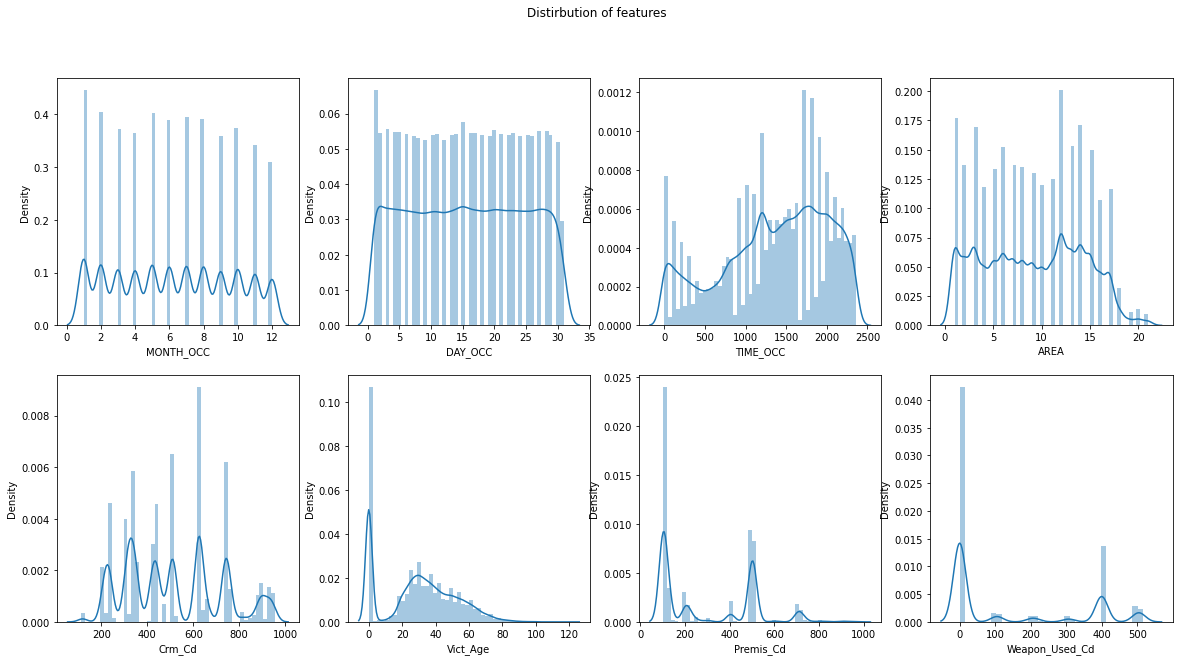

In [ ]:
# Check distribution of each features
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i, feature in enumerate(crimes_distribution.columns):
    row = int(i/4)
    col = i%4
    sns.distplot(crimes_distribution.iloc[:, i], ax=axs[row][col])

plt.suptitle('Distirbution of features')
plt.tight_layout

In [ ]:
# 'Vict_Age' which contains value of '0' are meaningless so drop all 'Vict_Age' which value is '0'
Vict_Age_0 = crimes_distribution[crimes_distribution['Vict_Age'] == 0].index
crimes_distribution.drop(Vict_Age_0, inplace=True)
crimes_distribution.reset_index(drop=True, inplace=True)

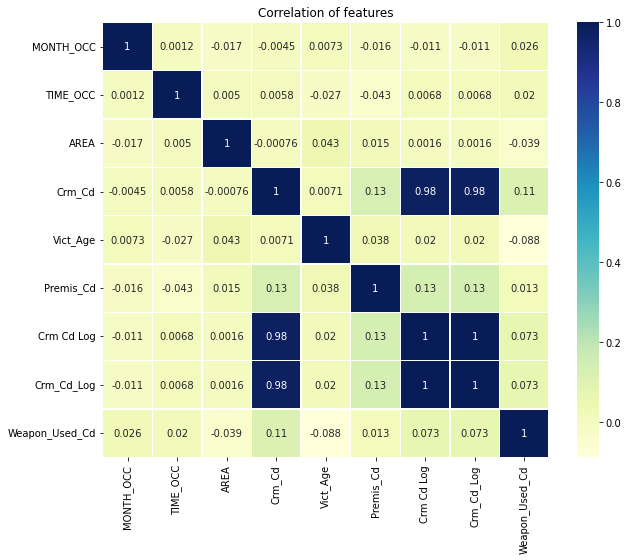

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
plt.title('Correlation of features')
sns.heatmap(crimes_distribution.corr(), annot=True, linewidths=.5, cmap="YlGnBu")

## MACHINE LEARNING 

In [ ]:
#importing libraries for classification
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
X = data[[x for x in data.columns if x != 'Crm Cd Desc']]
y = data['Crm Cd Desc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2303)

print(f'Training examples: {X_train.shape[0]}')
print(f'Test examples: {X_test.shape[0]}')
print('\nFeature names:')
print(*X.columns, sep='\t')

Training examples: 392821
Test examples: 98206

Feature names:
DR_NO	Date Rptd	DATE OCC	TIME OCC	AREA	AREA NAME	Rpt Dist No	Part 1-2	Crm Cd	Mocodes	Vict Age	Vict Sex	Vict Descent	Premis Cd	Premis Desc	Weapon Used Cd	Weapon Desc	Status	Status Desc	Crm Cd 1	Crm Cd 2	Crm Cd 3	Crm Cd 4	LOCATION	Cross Street	LAT	LON


In [ ]:
features = [x for x in data.columns if x != 'Crm Cd Desc']
categoricallist = list(data[features].select_dtypes(include=['object']).columns)
categoricallist

['Date Rptd',
 'DATE OCC',
 'AREA NAME',
 'Mocodes',
 'Vict Sex',
 'Vict Descent',
 'Premis Desc',
 'Weapon Desc',
 'Status',
 'Status Desc',
 'LOCATION',
 'Cross Street']

In [ ]:
numericallist = list(data.select_dtypes(exclude=['object']).columns)
numericallist

['DR_NO',
 'TIME OCC',
 'AREA',
 'Rpt Dist No',
 'Part 1-2',
 'Crm Cd',
 'Vict Age',
 'Premis Cd',
 'Weapon Used Cd',
 'Crm Cd 1',
 'Crm Cd 2',
 'Crm Cd 3',
 'Crm Cd 4',
 'LAT',
 'LON']

## BUILDING PIPELINES

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='most_frequent')),('create_dummies_cats', OneHotEncoder(handle_unknown='ignore'))])
y = cat_pipeline.fit_transform(np.array(X_train[categoricallist]))
y.shape

(392821, 208614)

In [ ]:
num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])
x = num_pipeline.fit_transform(np.array(X_train[numericallist]))
x.shape

(392821, 15)

In [ ]:
processing_pipeline = ColumnTransformer(transformers=[('proc_numericlist', num_pipeline, numericallist),
                                                      ('create_dummies', cat_pipeline, categoricallist)])
z = processing_pipeline.fit_transform(X_train)
z

<392821x208629 sparse matrix of type '<class 'numpy.float64'>'
	with 10606167 stored elements in Compressed Sparse Row format>

In [ ]:
processing_pipeline

ColumnTransformer(transformers=[('proc_numericlist',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['DR_NO', 'TIME OCC', 'AREA', 'Rpt Dist No',
                                  'Part 1-2', 'Crm Cd', 'Vict Age', 'Premis Cd',
                                  'Weapon Used Cd', 'Crm Cd 1', 'Crm Cd 2',
                                  'Crm Cd 3', 'Crm Cd 4', 'LAT', 'LON']),
                                ('create_dummies',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncod

## ALGORITHM - DECISION TREE

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('dt', DecisionTreeClassifier())]
)

param_grid = [
  {'dt__max_depth': [3, 5, 6, 8,10],
   'dt__min_samples_split':[2,4,6,8],
   'dt__min_samples_leaf': [3, 7],
   'dt__class_weight':[None, 'balanced']
  }
 ]

gcv_results = GridSearchCV(estimator=modeling_pipeline, 
                           param_grid=param_grid, scoring='accuracy', refit=True)

gcv_results = gcv_results.fit(X_train, y_train)

gcv_results.best_estimator_


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numericlist',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['DR_NO', 'TIME OCC', 'AREA',
                                                   'Rpt Dist No', 'Part 1-2',
                                                   'Crm Cd', 'Vict Age',
                                                   'Premis Cd',
                                                   'Weapon Used Cd', 'Crm Cd 1',
                                                   'Crm Cd 2', 'Crm Cd 3',
                                                   'Crm Cd 4', 'LAT', 'LON']),
   

In [ ]:
y_testp = gcv_results.predict(X_test)
y_testp_dt = gcv_results.predict_proba(X_test)

print(classification_report(y_test, y_testp))

                                                          precision    recall  f1-score   support

                                                   ARSON       1.00      1.00      1.00       306
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       1.00      1.00      1.00       140
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       1.00      1.00      1.00      5824
                                       ATTEMPTED ROBBERY       1.00      1.00      1.00       548
                                BATTERY - SIMPLE ASSAULT       1.00      1.00      1.00      7927
                                BATTERY ON A FIREFIGHTER       1.00      1.00      1.00        32
                                 BATTERY POLICE (SIMPLE)       1.00      1.00      1.00       270
                             BATTERY WITH SEXUAL CONTACT       0.00      0.00      0.00       425
                                                  BIGAMY       0.00      0.00      0.00         1
                   

#Questions for Descriptive Analysis

What are the highest crime rates in the City of Los Angeles? 

In [ ]:
df_highest_crime_rate = df1.select(['Crm_Cd','Crm_Cd_Desc'])

In [ ]:
df_highest_crime_rate = df_highest_crime_rate.dropna(how='any', subset = ['Crm_Cd','Crm_Cd_Desc'])

In [ ]:
df_highest_crime_rate = df_highest_crime_rate.withColumnRenamed('Crm_Cd','Crime_Code')\
                                             .withColumnRenamed('Crm_Cd_Desc',"Crime_Code_Desc")

In [ ]:
df_highest_crime_rate = df_highest_crime_rate.groupby(df_highest_crime_rate.Crime_Code_Desc).count().orderBy('count', ascending=False)

In [ ]:
df_highest_crime_rate.show()

+--------------------+-----+
|     Crime_Code_Desc|count|
+--------------------+-----+
|    VEHICLE - STOLEN|17177|
|BATTERY - SIMPLE ...|13420|
|VANDALISM - FELON...|10636|
|BURGLARY FROM VEH...|10575|
|            BURGLARY|10482|
|ASSAULT WITH DEAD...| 9263|
|THEFT PLAIN - PET...| 8805|
|INTIMATE PARTNER ...| 8504|
|THEFT FROM MOTOR ...| 7782|
|VANDALISM - MISDE...| 5712|
|             ROBBERY| 5579|
|   THEFT OF IDENTITY| 5273|
|THEFT-GRAND ($950...| 4405|
|CRIMINAL THREATS ...| 3394|
|SHOPLIFTING - PET...| 2790|
|     BRANDISH WEAPON| 2560|
|         TRESPASSING| 2436|
|INTIMATE PARTNER ...| 2209|
|VIOLATION OF REST...| 1910|
|       BIKE - STOLEN| 1817|
+--------------------+-----+
only showing top 20 rows



In [ ]:
#convert to pandas df
df_highest_crime_rate = df_highest_crime_rate.toPandas()
df_highest_crime_rate = df_highest_crime_rate.head(20)

In [ ]:
df_highest_crime_rate = df_highest_crime_rate.sort_values(by=['count'], ascending=True )

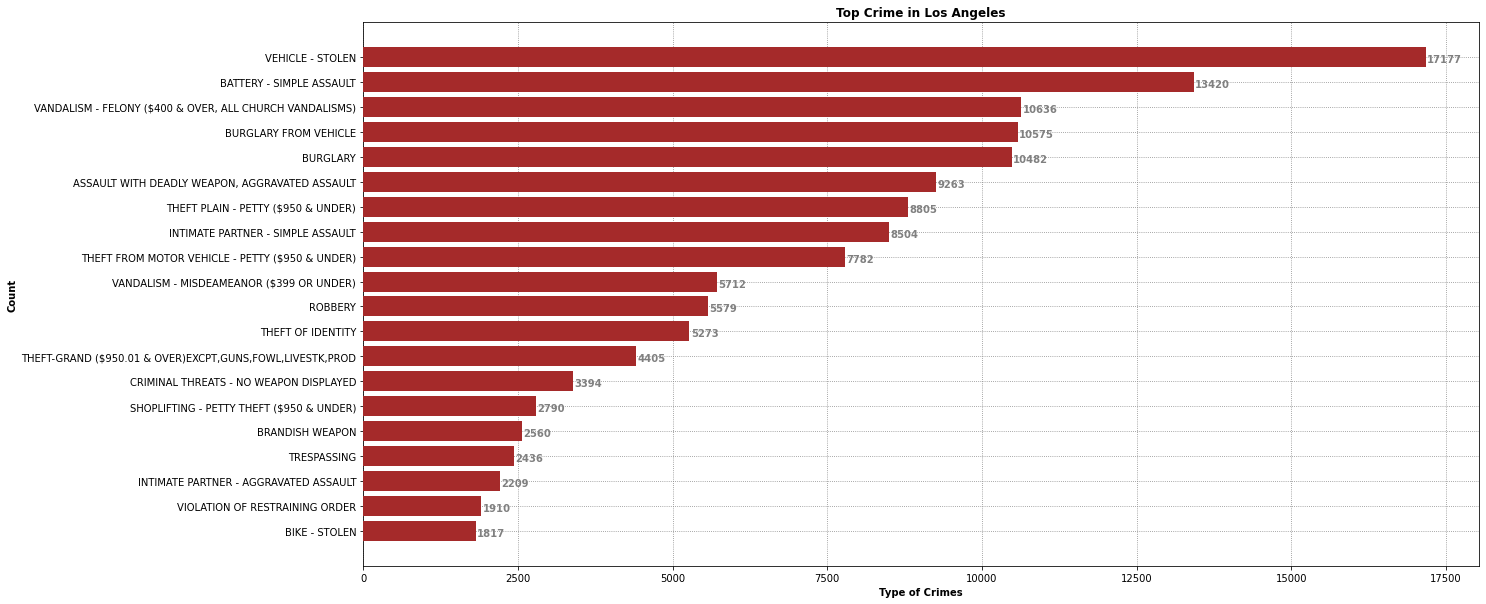

In [ ]:
#Set the figure size
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

#plot the horizontal bar chart with grid
plt.grid(zorder=0, color='grey', linestyle=':')
plt.barh(df_highest_crime_rate['Crime_Code_Desc'], df_highest_crime_rate['count'], color='#A52A2A',zorder=3)

#put every values next to the bar 
for i, v in enumerate(df_highest_crime_rate['count']):
    plt.text(v + 20, i - 0.2, str(v), color='grey', fontweight='bold')
  
#Label title, x-axis, and y-axis
plt.title('Top Crime in Los Angeles', fontweight='bold')
plt.xlabel('Type of Crimes', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.show()

During what time does the crime using gun as weapon occurred the most?

In [ ]:
# Filtering only rows with Hand guns or Semi-automatic pistols (by equal to)
data["Guns Only"] = data["Weapon Desc"][(data["Weapon Desc"] == "HAND GUN") | (data["Weapon Desc"] == "SEMI-AUTOMATIC PISTOL")]

In [ ]:
def makemil(time):
    ntime = ""
    if len(str(time)) == 1:
        ntime = "000" + str(time)
    if len(str(time)) == 2:
        ntime = "00" + str(time)
    if len(str(time)) == 3:
        ntime = "0" + str(time)
    if len(str(time)) == 4:
        ntime = str(time)
    return ntime

def returnhour(miltime):
    return miltime[:2]

In [ ]:
# Formatting to 4 char string
data["TIME OCC"] = data["TIME OCC"].apply(makemil)

In [ ]:
# Extracting the hour out from time
data["Hour Occurred"] = data["TIME OCC"].apply(returnhour)

In [ ]:
# Group by Guns Only and Hour Occurred
cc_gender = data.groupby(["Hour Occurred", "Guns Only"]).size().reset_index(name="Count")
cc_gender.tail(6)

,Hour Occurred,Guns Only,Count
42,21,HAND GUN,809
43,21,SEMI-AUTOMATIC PISTOL,315
44,22,HAND GUN,758
45,22,SEMI-AUTOMATIC PISTOL,280
46,23,HAND GUN,714
47,23,SEMI-AUTOMATIC PISTOL,227


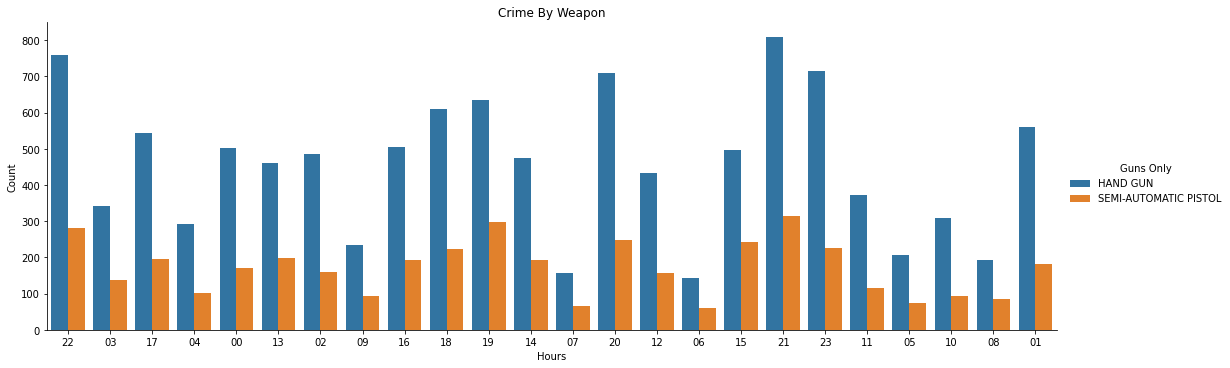

In [ ]:
#weapon used in each hours
ax = sns.factorplot(x="Hour Occurred", hue="Guns Only", kind="count", data=data, size=5, aspect=3)

plt.title("Crime By Weapon")
ax.set_xlabels("Hours")
ax.set_ylabels("Count")
sns.despine()

#Questions for Causal Analysis 

What kind of crime happens to a certain type of premise?

In [ ]:
# Display top 10 types of crime
topcrimetype = data["Crm Cd Desc"].value_counts().head(10).index
crimepremtype = data.loc[data["Crm Cd Desc"].isin(topcrimetype)]

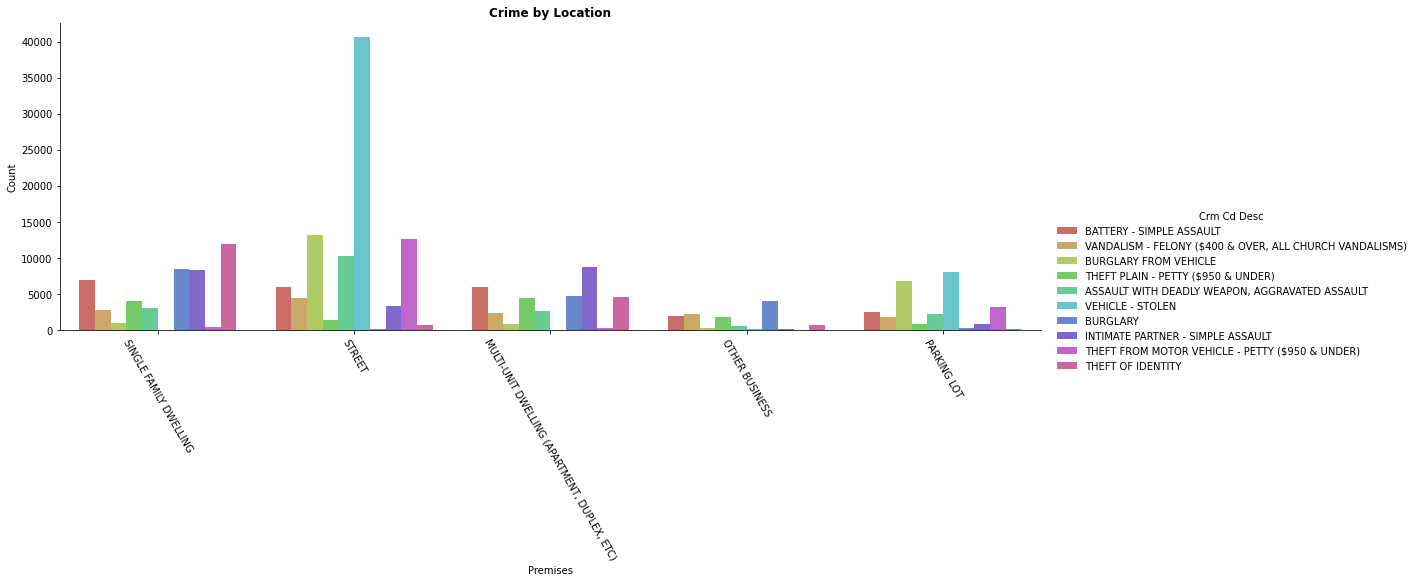

In [ ]:
# Type of Crime and their Location
sns.set_palette("hls", n_colors=10)
ax = sns.factorplot(x="Public Premise", hue="Crm Cd Desc", kind="count", data=crimepremtype, size=5, aspect=3)
plt.title("Crime by Location", fontweight = 'bold')
ax.set_xticklabels(rotation=-60)
ax.set_xlabels("Premises")
ax.set_ylabels("Count")
sns.despine()

When do crime happens to a certain type of premise? 

In [ ]:
data["Premis Desc"].value_counts().head(5)

STREET                                          125623
SINGLE FAMILY DWELLING                           80902
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)     59078
PARKING LOT                                      36449
OTHER BUSINESS                                   22327
Name: Premis Desc, dtype: int64

In [ ]:
# Filtering crimes by top 5
data["Public Premise"] = data["Premis Desc"][(data["Premis Desc"] == "STREET") |
                                                       (data["Premis Desc"] == "SINGLE FAMILY DWELLING") | 
                                                       (data["Premis Desc"] == "MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)") |
                                                       (data["Premis Desc"] == "PARKING LOT") |
                                                       (data["Premis Desc"] == "OTHER BUSINESS")]

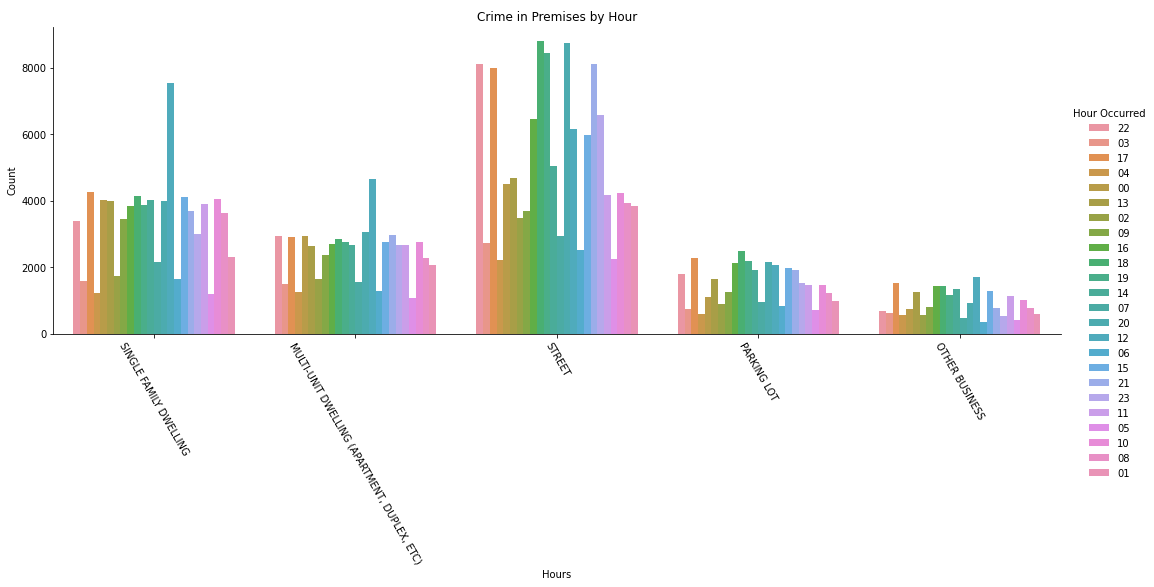

In [ ]:
# Factorplot Crime, Premises and Hour Occured
ax = sns.factorplot(x="Public Premise", hue="Hour Occurred", kind="count", data=data, size=5, aspect=3)
plt.title("Crime in Premises by Hour")
ax.set_xticklabels(rotation=-60)
ax.set_xlabels("Hours")
ax.set_ylabels("Count")
sns.despine()

#Questions for Exploratory Analysis 

What is the trend of crime in the first half of the year 2020 as compared to the second half? 

In [ ]:
df_trend_2020 = df1.select(['Crm_Cd','Crm_Cd_Desc','MONTH_OCC'])

In [ ]:
df_trend_2020 = df_trend_2020.dropna(how='any', subset = ['Crm_Cd','Crm_Cd_Desc','MONTH_OCC'])

In [ ]:
#Renaming a column
df_trend_2020 = df_trend_2020.withColumnRenamed('Crm_Cd_Desc','Crime_Desc')

In [ ]:
df_trend_2020 = df_trend_2020.groupby(df_trend_2020.MONTH_OCC).count().orderBy('MONTH_OCC', ascending=True)

In [ ]:
df_trend_2020.show()

+---------+-----+
|MONTH_OCC|count|
+---------+-----+
|        1|15253|
|        2|13838|
|        3|12711|
|        4|12489|
|        5|13782|
|        6|13341|
|        7|13490|
|        8|13392|
|        9|12286|
|       10|12818|
|       11|11677|
|       12|10574|
+---------+-----+



In [ ]:
df_first_half = df_trend_2020.filter((df_trend_2020.MONTH_OCC >= 1) & (df_trend_2020.MONTH_OCC <= 6))
df_second_half = df_trend_2020.filter((df_trend_2020.MONTH_OCC >= 7) & (df_trend_2020.MONTH_OCC <= 12))

In [ ]:
df_second_half = df_second_half.withColumn("MONTH_OCC", when((df_second_half.MONTH_OCC == 7), lit(1)).
                                  when((df_second_half.MONTH_OCC == 8), lit(2)).
                                  when((df_second_half.MONTH_OCC == 9), lit(3)).
                                  when((df_second_half.MONTH_OCC == 10), lit(4)).
                                  when((df_second_half.MONTH_OCC == 11), lit(5)).
                                  otherwise(lit(6)))

In [ ]:
df_second_half.show()

+---------+-----+
|MONTH_OCC|count|
+---------+-----+
|        1|13490|
|        2|13392|
|        3|12286|
|        4|12818|
|        5|11677|
|        6|10574|
+---------+-----+



In [ ]:
#exchange to pandas df
df_first_half = df_first_half.toPandas()
df_second_half = df_second_half.toPandas()

Text(0, 0.5, 'Count')

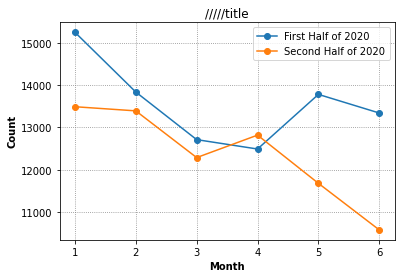

In [ ]:
#Double line plot
plt.grid(zorder=0, color='grey', linestyle=':')
plt.plot(df_first_half['MONTH_OCC'], df_first_half['count'], label = 'First Half of 2020', marker='o')
plt.plot(df_second_half['MONTH_OCC'], df_second_half['count'], label = 'Second Half of 2020',marker='o')
plt.legend()

#Label title, x-axis, and y-axis
plt.title('Trend of Crime in First Half & Second Half of 2020', fontweight='bold')
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

#Questions for Inferential Analysis 

Which gender has more risk of becoming the victim of rape in the Central area? 

In [ ]:
df_gender_victim_rape = df1.select(['Crm_Cd','Crm_Cd_Desc','AREA_NAME','Vict_Sex'])
df_gender_victim_rape = df_gender_victim_rape.dropna(how='any', subset = ['Crm_Cd','Crm_Cd_Desc','AREA_NAME','Vict_Sex'])

In [ ]:
#Filter the column Crime_Desc that contais string 'RAPE'
df_gender_victim_rape = df_gender_victim_rape.filter(df_gender_victim_rape.Crm_Cd_Desc.contains('RAPE'))
df_gender_victim_rape = df_gender_victim_rape.where(df_gender_victim_rape.AREA_NAME == 'Central')

In [ ]:
df_gender_victim_rape.show()

+------+---------------+---------+--------+
|Crm_Cd|    Crm_Cd_Desc|AREA_NAME|Vict_Sex|
+------+---------------+---------+--------+
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   122|RAPE, ATTEMPTED|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Central|       F|
|   121| RAPE, FORCIBLE|  Centra

In [ ]:
#Find the count of victims of rape by gender
df_gender_victim_rape = df_gender_victim_rape.groupby(df_gender_victim_rape.Vict_Sex).count()

In [ ]:
#convert to pandas df
df_gender_victim_rape = df_gender_victim_rape.toPandas()

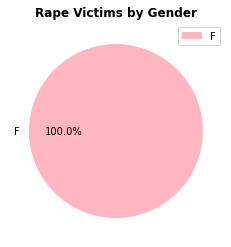

In [ ]:
mycolors = ["#FFB6C1", "#728FCE"]
 
#percentage for pie chart functions
def func(pct):
  return "{:1.1f}%".format(pct)

#plotting piechart
plt.pie(df_gender_victim_rape['count'], labels = df_gender_victim_rape['Vict_Sex'], colors = mycolors,
         autopct=lambda pct: func(pct))

plt.legend()

#Label the title
plt.title('Rape Victims by Gender', fontweight='bold')
plt.show() 

Are certain genders more likely to become victims of specific crimes? 

In [ ]:
#Drop H and X
data.drop(data[data['Vict Sex'] == 'H'].index, axis=0, inplace=True)
data.drop(data[data['Vict Sex'] == 'X'].index, axis=0, inplace=True)
data['Vict Sex'].value_counts()

M    66098
F    55158
Name: Vict Sex, dtype: int64

In [ ]:
victim_gender_crime = data[["Crm Cd Desc", "Vict Sex"]]
crime_frequency = victim_gender_crime['Crm Cd Desc'].value_counts().head().index
crime_victim_gender = data.loc[data["Crm Cd Desc"].isin(crime_frequency)]

#Group by Crm Cd Desc and Vict Sex
crime_crm_cd = crime_victim_gender.groupby(["Crm Cd Desc", "Vict Sex"]).size().reset_index(name="Count")
print('Crime Code Description with Victim Gender')
crime_crm_cd

Crime Code Description with Victim Gender


,Crm Cd Desc,Vict Sex,Count
0,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",F,2416
1,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",M,6679
2,BATTERY - SIMPLE ASSAULT,F,6338
3,BATTERY - SIMPLE ASSAULT,M,7030
4,BURGLARY FROM VEHICLE,F,4426
5,BURGLARY FROM VEHICLE,M,5926
6,INTIMATE PARTNER - SIMPLE ASSAULT,F,6351
7,INTIMATE PARTNER - SIMPLE ASSAULT,M,2139
8,VEHICLE - STOLEN,F,11
9,VEHICLE - STOLEN,M,51


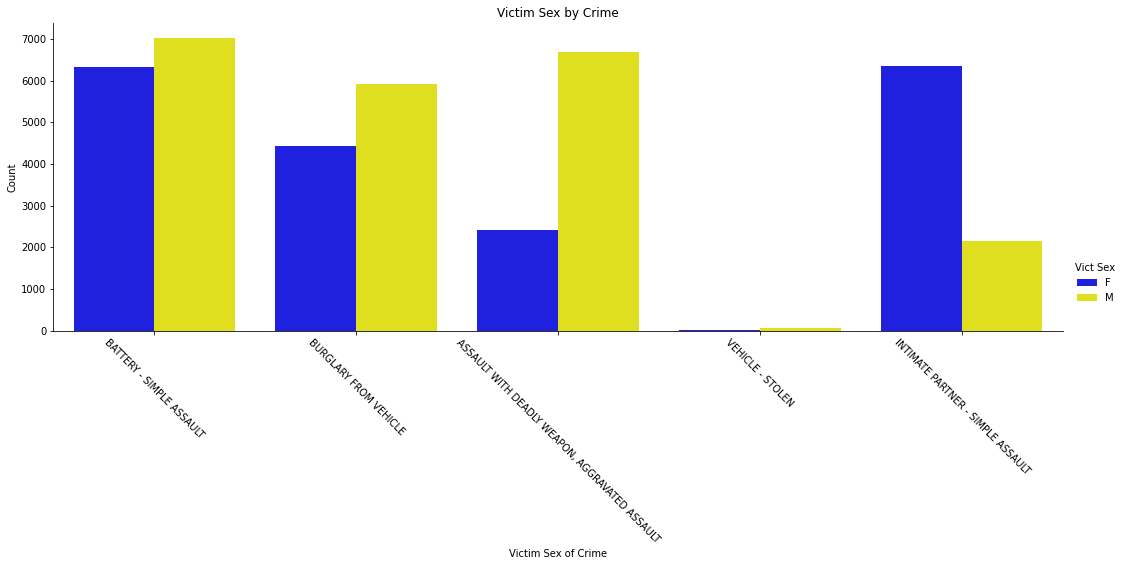

In [ ]:
#Create barplot
ax = sns.catplot(x="Crm Cd Desc", hue="Vict Sex", kind="count", data=crime_victim_gender, height=5, aspect=3, palette=["blue", "yellow"])
plt.title("Victim Sex by Crime")
ax.set_xticklabels(rotation=-45)
ax.set_xlabels("Victim Sex of Crime")
ax.set_ylabels("Count")
sns.despine()

Are certain ages more likely to become victims of specific crimes? 

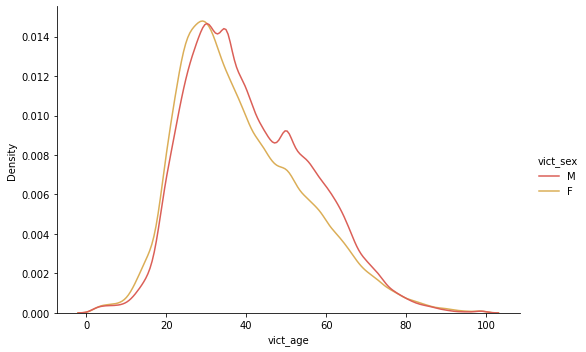

In [ ]:
df1.createOrReplaceTempView('dataset')
df_age = spark.sql(''' SELECT vict_sex, vict_age FROM dataset WHERE NOT vict_sex = 'X' AND NOT vict_sex = 'H' AND vict_age > 0 ORDER BY vict_sex DESC''')
dv_age = df_age.toPandas()
chart = sns.displot(data=dv_age, x='vict_age', hue='vict_sex', kind='kde', height=5, aspect=1.5)

Which area is the most dangerous and most safe to stay in? 

In [ ]:
#Count number for crimes reported on each community police station
Crime_count_by_area = data.groupby('AREA NAME').agg(['count'])
Crime_count_by_area.reset_index(inplace=True)
Crime_count_by_area.columns = Crime_count_by_area.columns.droplevel(level=1)
Crime_count_by_area.rename(columns={"DR_NO": "NumberofCrimes"}, inplace=True)
#Rename n Hollywood to North Hollywood
Crime_count_by_area['AREA NAME'].loc[Crime_count_by_area['AREA NAME']=='N Hollywood'] = 'North Hollywood'
Crime_count_by_area.sort_values(by="NumberofCrimes", ascending=False).head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,AREA NAME,NumberofCrimes,Date Rptd,DATE OCC,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,Guns Only,Hour Occurred
0,77th Street,11439,11439,11439,11439,11439,11439,11439,11439,11439,...,11439,777,43,0,11439,2940,11439,11439,733,11439
1,Central,9956,9956,9956,9956,9956,9956,9956,9956,9956,...,9955,860,2,0,9956,2929,9956,9956,202,9956
15,Southwest,9391,9391,9391,9391,9391,9391,9391,9391,9391,...,9391,286,9,0,9391,1774,9391,9391,368,9391
8,North Hollywood,9284,9284,9284,9284,9284,9284,9284,9284,9284,...,9284,688,21,1,9284,1107,9284,9284,175,9284
9,Newton,8975,8975,8975,8975,8975,8975,8975,8975,8975,...,8975,861,24,1,8975,2601,8975,8975,558,8975


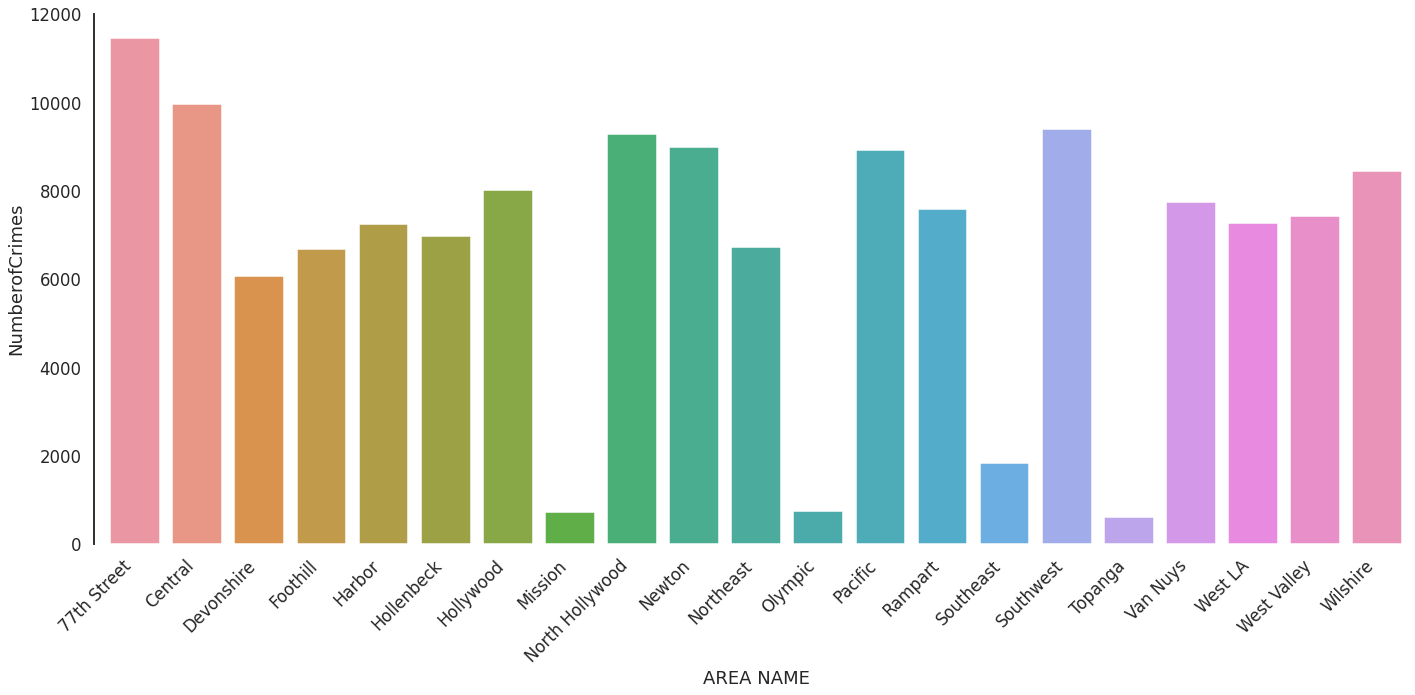

In [ ]:
plt.figure(figsize=(20, 10))

sns.set(style="white", context="talk", palette="pastel")

sns.barplot(
    data=Crime_count_by_area,
    x=Crime_count_by_area["AREA NAME"],
    y=Crime_count_by_area["NumberofCrimes"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)